# Practical Project 

The aim of this project is to solve various forms of the portfolio optimization problem through Julia/computer software. This program template will provide hints/template code for you to focus on the optimization formulation part.

As usual, we first need to load a few packages in Julia.

# Part I - Compulsory Task

In [1]:
# Load the JuMP related packages and several solvers
# ECOS - for solving SOCP problems
# Juniper & Ipopt - for solving MI-NLP problems
using JuMP, Juniper, ECOS, Ipopt
# Load the data/file processing related packages
using CSV, Glob, DataFrames, Statistics
# Load the Plot package for illustrating the solution
using Plots
# Load the custom functions for benchmarking  
include("./reusablefunc.jl");

#### Data Preprocessing
The first step is to load the raw data into the memory. The following codes are provided for you to help you get started. 

In [2]:
# Change "subgroup1" to other names according to the subgroup you are assigned.
path_subgroup = "./ftec_project_subgroup2/" 
files = glob( "*_train.csv", path_subgroup );
dfs = DataFrame.( CSV.File.( files ) );

In [3]:
T = 800; n = length(dfs);
stocks_retur = zeros(T,n);
for i = 1:n
    # compute the realized return R_i(t)
    stocks_retur[:,i] = (dfs[i].close-dfs[i].open) ./ dfs[i].open;
end
names_stocks = [ dfs[i].Name[1] for i in 1:n ];

## Task 4: Warm-up Exercise

For part (a) of this task, you have to plot the return of 3-4 stocks over time. An example is provided for you as follows. Use "Insert" -> "Insert Cell Below/After" if you want to keep the plots together in one place.

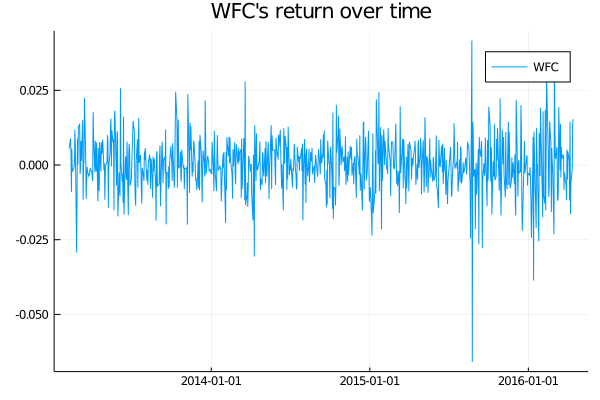

In [21]:
stock_id = 1; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].date, stocks_retur[:,stock_id] , label = dfs[stock_id].Name[1], title = dfs[stock_id].Name[1]*"'s return over time" )

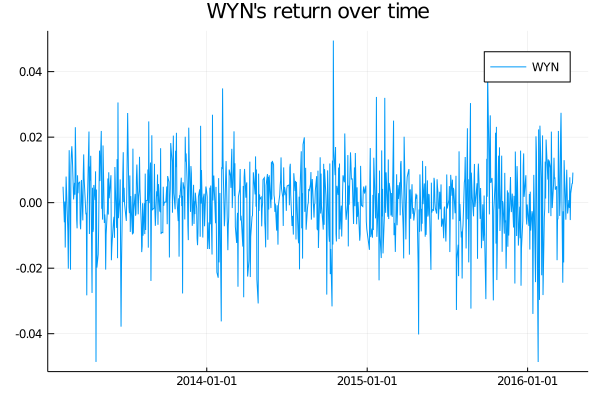

In [22]:
stock_id = 8; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].date, stocks_retur[:,stock_id] , label = dfs[stock_id].Name[1], title = dfs[stock_id].Name[1]*"'s return over time" )

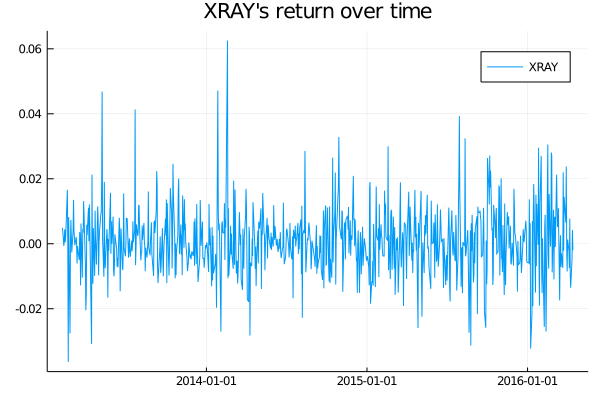

In [23]:
stock_id = 15; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].date, stocks_retur[:,stock_id] , label = dfs[stock_id].Name[1], title = dfs[stock_id].Name[1]*"'s return over time" )

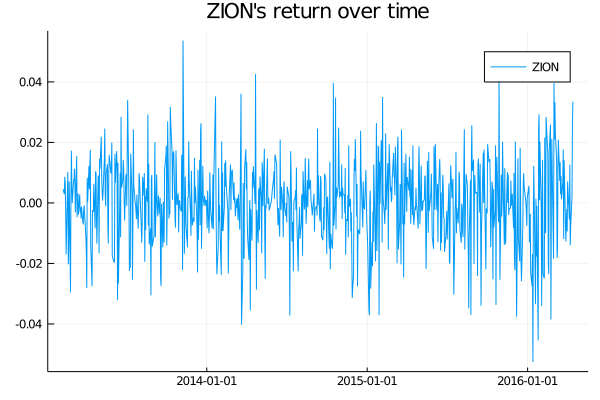

In [24]:
stock_id = 20; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].date, stocks_retur[:,stock_id] , label = dfs[stock_id].Name[1], title = dfs[stock_id].Name[1]*"'s return over time" )

For part (b) of this task, we need to estimate the expected return $\hat{r}_i$ and covariance $\hat\rho_{ij}$. Notice that these terms are given by (1.6) in the project specification. For your convenience, they have been calculated as follows:

In [ ]:
# calculate r_i and Sigma
bar_R = [ mean( stocks_retur[:,i] ) for i in 1:length(dfs) ];
Sigma = [ mean( (stocks_retur[:,i].-bar_R[i]).*(stocks_retur[:,j].-bar_R[j]) ) for i=1:n, j=1:n ]; 

where "bar_R" is a $20$-dimensional vector containing the expected return $\hat{r}$ for the stocks; and "Sigma" is the $20 \times 20$ matrix of the covariance. 

## Task 5: Closed Form Solution to (1.1)

This task computes the optimal portfolio using the closed form solution derived in Task 1. Here are a few hints of useful syntax in computing the optimal solution:

- To compute the inverse of a square matrix, e.g., "$\texttt{Sigma}$", it can be done by 
$$\texttt{Sigma^-1}$$
- To create a (column) vector of all ones of $n$-dimensional. you may use 
$$\texttt{ones(n)}.$$ 
- In your closed form solution, you may need encounter something such as ${\bf 1}^\top {S} {b}$ for some $n \times n$ square matrix ${S}$, and $n$-dimensional vector ${b}$. The above expression can be computed in Julia as
$$\texttt{ones(n)'*S*b}$$
where $\texttt{ones(n)'}$ has denoted the transpose of the vector $\texttt{ones(n)}$. 

In [ ]:
# your code here

Suppose that $\texttt{portfolio_opt}$ has been created as a 20-dimensional vector of the optimal portfolio. The following helper code should plot the comparison of the portfolio for you. 

In [ ]:
plot( names_stocks, portfolio_opt, labels = "portfolio", xticks = :all )
# you may adjust the scale factor "1000" to scale up/down the expected return to make it comparable with 
# the value of the portfolio (*for improved visualization only*).
plot!( names_stocks, 1000*bar_R , labels = "(scaled) expected return") 
plot!( names_stocks, 1000*[Sigma[i,i] for i in 1:n], labels = "(scaled) variance" )

## Task 6 (a): Mixed Integer Programming Solution

For this task, we shall implement the MI-NLP problem. As usual, we have to define the optimization object and specify a few parameters, as follows. The solver we are going to apply is "Juniper".

In [ ]:
# the following code specifies the constants as described in the problem
M = 20; B = 20; c = 2; w = 1*ones(n); Rd = 1.01*sum( w.*bar_R ); 

# the following code setup the JuMP model with the right solver
nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
optimizer = Juniper.Optimizer
model = Model(optimizer_with_attributes(optimizer, "nl_solver"=>nl_solver, "atol"=>1e-10));

You can program the MI-NLP problem in the following cell and solve it. Here are a few hints that maybe useful.

- To be compatible with the helper codes in the latter section, please call the decision variable for the portfolio by "x_mip". 
- You may use for-loop to specify a large number of constraints. 
- To model constraint given in the form of 
$$ \sum_{i=1}^n x_i y_i \geq r $$
withe the $n$-dimensional vectors $x$, $y$. You may do so by

$$ \texttt{@constraint(model, sum( x .* y ) >= r)} $$

where $\texttt{.*}$ denotes an "element-wise" product 
- To minimize quadratic function of the form
$$ f(x) = x^\top \Sigma x $$

we first notice that 

$$ f(x) = ( \Sigma^{1/2} x )^\top ( \Sigma^{1/2} x ) $$

and the above can be modeled in JuMP by

$$ \texttt{@variable( model, y[1:n] )}$$
$$ \texttt{@constraint( model, y .== sqrt(Sigma)*x );}$$ 
$$ \texttt{@NLobjective( model, Min, sum(y[i]^2 for i in 1:n) )} $$

Notice that we shall use "$\texttt{NLObjective}$ to specify that the objective function is nonlinear.

In [ ]:
# your code here
optimize!(model)

## Task 6(b): SOCP Solution

For this task, we shall implement the SOCP program formulated in Task 3. As usual, we have to define the optimization object and specify a few parameters, as follows. The solver we are going to apply is "ECOS".

In [ ]:
# specify the problem parameters
M = 20; B = 20; a = 2; w = ones(n); Rd = 1.01*sum( w.*bar_R ); 
# specify the JuMP model with ECOS as the optimizer
m_socp = Model( ECOS.Optimizer );

You may program the SOCP problem into JuMP as follows. Again, for convenience, you may name the decision variable of the portfolio as "x_socp". 

Further, wou may find that some constraints are similar to the MI-NLP from the previous task. However, when you "copy-and-paste" those code, don't forget to change the model name and the variable name. Here are some hints on modeling the second order cone constraints:

- To model a SOC constraint given in the form

$$ \| Ax + d \| \leq c^\top x + d, $$

you can use

$$ \texttt{ @constraint( m_socp, [c'*x + d; A*x + d] in SecondOrderCone() ) } $$

Essentially, "$\texttt{[c'*x + d; A*x + d]}$" defines a vector whose first element describes the RHS of the SOC constraint, the the remaining elements describe the vector found inside the norm of the SOC constraint. 

In [ ]:
# your code here
optimize!(m_socp)

## Task 6(c): Plotting the portfolios found

Given that you have programmed and executed the optimization problems correctly, the following helper code shall plot the portfolios nicely for you. 

In [ ]:
plot( names_stocks, portfolio_opt, labels = "unconstrained portfolio" )
plot!( names_stocks, JuMP.value.(x + w), labels = "MI-SOCP")
plot!( names_stocks, JuMP.value.(x_socp + w), labels = "SOCP")
plot!( names_stocks, 1000*bar_R, labels ="(Scaled) Expected Return")
plot!( names_stocks, 1000*[Sigma[i,i] for i in 1:n], labels ="(Scaled) Variance")

## Task 7: Evaluating the Solution on Testing Set

Again, provided that you have programmed and executed the optimization problems correctly, the following helper code shall compute the Sharpe ratio and other benchmarks for you.

In [ ]:
sharpe_IP = sharpe_ratio( path_subgroup, JuMP.value.(x_mip), ones(n), 2 );

In [ ]:
sharpe_SOCP = sharpe_ratio( path_subgroup, JuMP.value.(x_socp), ones(n) , 2 );

In [ ]:
sharpe_Opt = sharpe_ratio( path_subgroup, portfolio_opt, zeros(n), 2 );

# Part II - Competitive Task

In the compulsory task, we shall implement a projected gradient method (using a constant step size) for the approximated Portfolio optimization problem. 

We shall consider the full portfolio optimization problem. For this, let us first load the stock data with the following helper code.

In [ ]:
# load the full data set!
files = glob( "*_train.csv", "./ftec_project_files/");
dfs = DataFrame.( CSV.File.( files ) );
T = 800; n = length(dfs);
stocks_retur_full = zeros(T,n);
for i = 1:n
    # compute the realized return R_i(t)
    stocks_retur_full[:,i] = (dfs[i].close-dfs[i].open) ./ dfs[i].open;
end
names_stocks_full = [ dfs[i].Name[1] for i in 1:n ];
# calculate r_i and Sigma
bar_R_full = [ mean( stocks_retur_full[:,i] ) for i in 1:length(dfs) ];
Sigma_full = [ mean( (stocks_retur_full[:,i].-bar_R_full[i]).*(stocks_retur_full[:,j].-bar_R_full[j]) ) for i=1:n, j=1:n ]; 

Notice that "bar_R_full" is the expected return for all the $n=471$ stocks considered, and "Sigma_full" is the $471 \times 471$ covariance matrix for them. 

## Task 8: Implementing a Customized Solver for Approximated problem

You shall write a few helper functions to compute the objective values, the gradient vector, the projection into the box constraint, etc.. to help you with implementing the customized solver. Some useful syntax are as follows:

- For a nonlinear function $h(z)$ (such as the Huber function) on a scalar $z$. Suppose that $x$ is an $n$-dimensional vector, to create the vector 

$$ [h(x)]_i = h(x_i) $$

you may use the syntax

$$ \texttt{h.(x)} $$

where the "." after "h" broadcasts the function to every elements of the vector. 
- Note that the objective function should be dependent on "x", "w", "a", "bar_R_full", "Sigma_full", "upsilon", "zeta". 

In [ ]:
# your code/functions here

You may program the iterative algorithm of your choice as follows. 

In [ ]:
# set the parameters as specified by the problem
M = 20; w = 1*ones(n); a = 0.75; upsilon = 1000; lambda = 0.5; delta = 0.01;

# initialize the algorithm
x_custom = zeros(n); 
store_obj = []
push!(store_obj, .. ) # replace ".." with the function you wrote for computing the objective val.

# calculate l and u - your code here (should be a simple formula)


for iteration_no = 1 : 50000 # feel free to adjust the number of iterations run here.
    # your code here
    
    push!(store_obj, .. ) # replace ".." with the function you wrote for computing the objective val.
end

In [ ]:
plot( store_obj, title = "objective value") # plot the trajectory of the optimization algorithm

Apply the post-processing step as specified in the project.

In [ ]:
x_custom_pp = copy( x_custom )
x_custom_pp[ abs.(x_custom_pp) .< delta ] .= 0;

The following code computes the sharpe ratio, return, transaction cost, total cost of portfolio which will be used to calculate your score for the competitive task!

In [ ]:
sharpe_PPGD = sharpe_ratio( "./ftec_project_files/", x_custom_pp, ones(n), 2 )

It may also help to visualize the portfolio with the following code:

In [ ]:
plot( names_stocks_full, x_custom_pp + w, labels = "gradient descent" )
plot!( names_stocks_full, 1000*bar_R_full, labels ="(Scaled) Expected Return")
plot!( names_stocks_full, 1000*[Sigma_full[i,i] for i in 1:n], labels ="(Scaled) Variance")